In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [4]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
from sklearn.model_selection import train_test_split

dataset_dir = r"\Users\My PC\OneDrive\Desktop\ACL_project\ACL"


In [7]:
image_files = []
labels = []

injury_folder = os.path.join(dataset_dir, 'injury')
for filename in os.listdir(injury_folder):
    image_files.append(os.path.join(injury_folder, filename))
    labels.append(1)  # Assign label 1 for 'injury'

no_injury_folder = os.path.join(dataset_dir, 'no_injury')
for filename in os.listdir(no_injury_folder):
    image_files.append(os.path.join(no_injury_folder, filename))
    labels.append(0)  # Assign label 0 for 'no_injury'

In [8]:
df = pd.DataFrame({
    'filename': image_files,
    'label': labels
})


In [9]:
image_files[0:5]

['\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a1.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a10.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a11.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a12.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a13.jpg']

In [10]:
labels[0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [11]:
labels[20:-1]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Convert labels column to string


In [12]:
df['label'] = df['label'].astype(str)

In [13]:

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Display the shapes
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (25, 2)
Validation set shape: (7, 2)
Test set shape: (8, 2)


In [14]:
df.head()


,filename,label
0,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
1,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
2,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
3,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
4,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1


In [15]:
df.tail()

,filename,label
35,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
36,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
37,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
38,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
39,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0


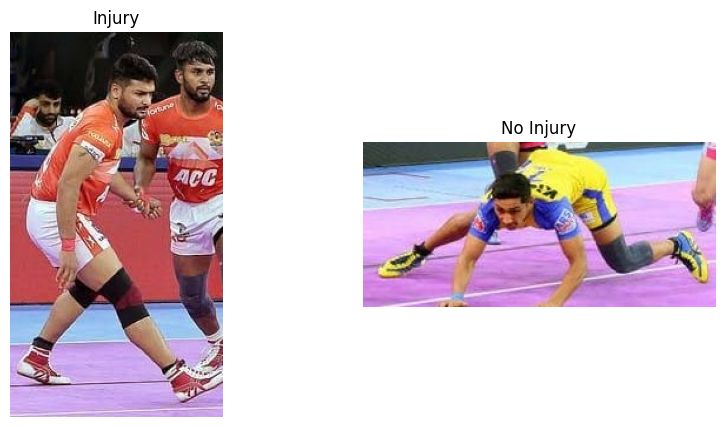

In [16]:

import cv2
import random

# Function to display one random image
def display_random_images(df):
    injury_sample = df[df['label'] == '0'].sample(n=1, random_state=random.randint(0, 1000)).iloc[0]['filename']
    no_injury_sample = df[df['label'] == '1'].sample(n=1, random_state=random.randint(0, 1000)).iloc[0]['filename']

    injury_image = cv2.imread(injury_sample)
    no_injury_image = cv2.imread(no_injury_sample)

    # Convert images from BGR to RGB
    injury_image = cv2.cvtColor(injury_image, cv2.COLOR_BGR2RGB)
    no_injury_image = cv2.cvtColor(no_injury_image, cv2.COLOR_BGR2RGB)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display
    axes[0].imshow(injury_image)
    axes[0].set_title('Injury')
    axes[0].axis('off')

    axes[1].imshow(no_injury_image)
    axes[1].set_title('No Injury')
    axes[1].axis('off')

    plt.show()

display_random_images(train_df)


Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
0 is for injury
1 is for no_injury


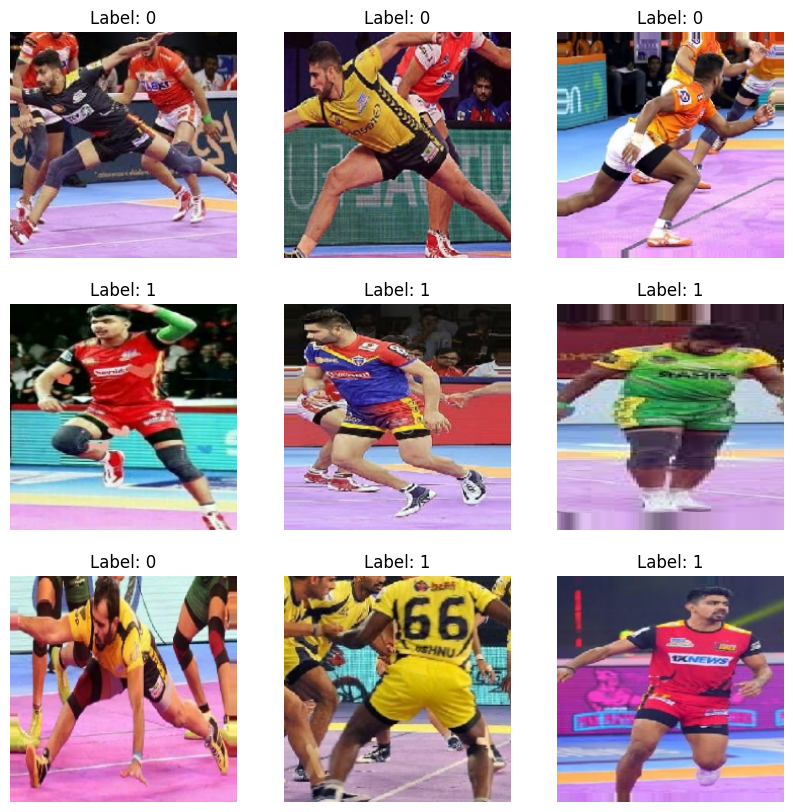

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


# Display a few augmented images
example_batch = next(train_generator)
example_images, example_labels = example_batch

print("0 is for injury")
print("1 is for no_injury")
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(example_images[i])
    plt.title(f"Label: {int(example_labels[i])}")
    plt.axis('off')
plt.show()


In [ ]:
# Load the VGG16 model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the first few layers of the base model
for layer in base_model.layers[:15]:
    layer.trainable = False

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 0.7484 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 0.6848 - val_accuracy: 0.6250 - val_loss: 0.6360
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5312 - loss: 0.6433 - val_accuracy: 0.8750 - val_loss: 0.5608
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9375 - loss: 0.5970 - val_accuracy: 1.0000 - val_loss: 0.4994
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.8438 - loss: 0.5621 - val_accuracy: 1.0000 - val_loss: 0.3860
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.8438 - loss: 0.4990 - val_accuracy: 1.0000 - val_loss: 0.3287
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.8750 - loss: 0.4180 - val_accuracy: 1.0000 - val_loss: 0.2398
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.9062 - loss: 0.3459 - val_accuracy: 1.0000 - val_loss: 0.2373
Epoch 9/

In [77]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,452,549 (116.17 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 15,211,524 (58.03 MB)

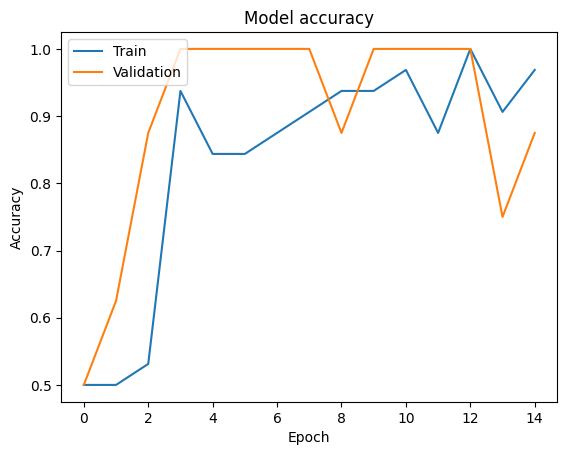

In [78]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [79]:
# Get final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


Final Training Accuracy: 0.9688
Final Validation Accuracy: 0.8750


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


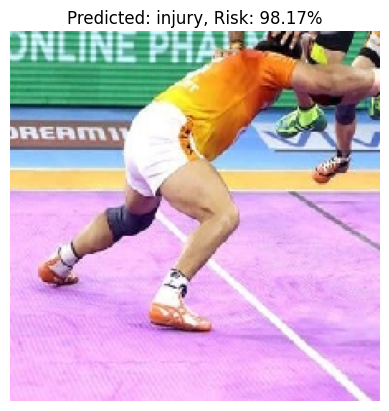

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


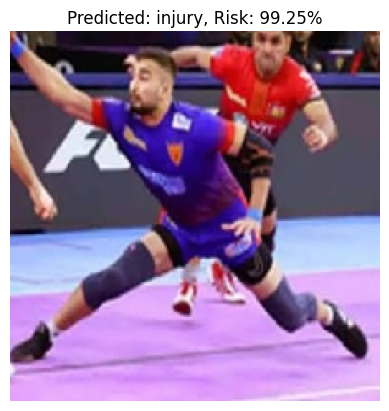

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


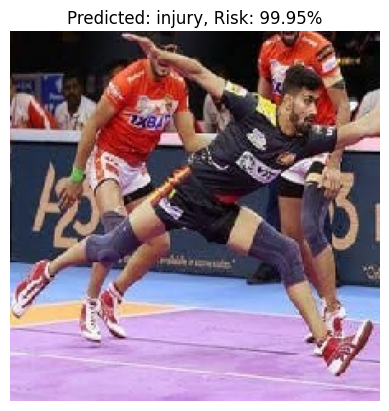

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


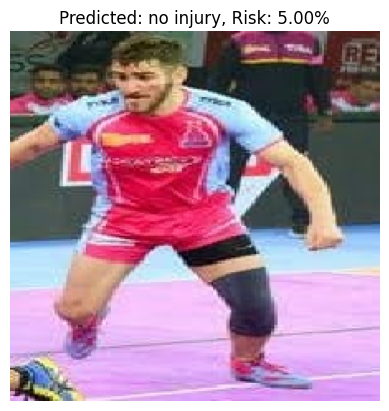

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


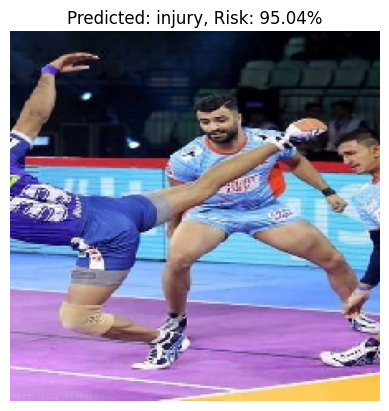

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


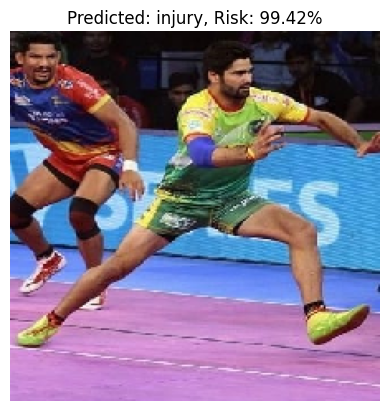

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


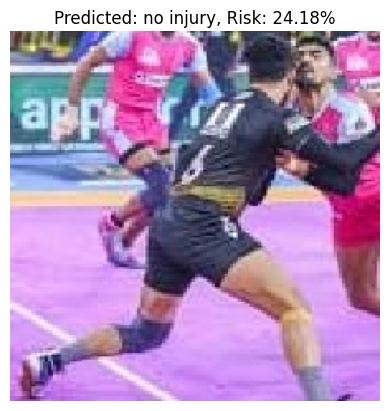

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


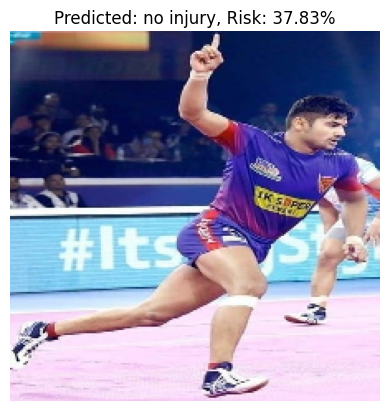

In [80]:
# Define a function to predict the class of a single image
def predict_image(model, img_path):
    """Predict the class of a single image using the trained model."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    prediction = model.predict(img_array)[0][0]  # Assuming binary classification output
    return prediction

# Iterate over each image in the test dataset
for index, row in test_df.iterrows():
    img_path = row['filename']
    true_label = row['label']
    predicted_prob = predict_image(model, img_path)
    predicted_label = 'injury' if predicted_prob < 0.5 else 'no injury'  # Assuming threshold of 0.5 for binary classification
    
    # Invert the probability value to reflect higher risk with higher values
    inverted_prob = 1 - predicted_prob
    
    # Convert the inverted probability to percentage
    inverted_prob_percent = inverted_prob * 100

    # Load and display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}, Risk: {inverted_prob_percent:.2f}%")
    plt.axis('off')
    plt.show()


In [82]:
# Save the model with .keras extension
#model.save('ACL_PREDICTION_0.1.keras')
